<h1> Overlapping Clusters - improving the network </h1>
Date: 24th March 2023

After successfully running a network that learns something (stage4_first_network) I will now try to improve it by increasing the size of the network!.

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

In [2]:
rootfile = uproot.open('./stage4_clusters.root')
ipd = hf.InputData_2photon(rootfile)
ipd.form_cluster()
ipd.train_test_split()
ipd.prep_trainingsdata()
ipd.prep_verificationdata()

Initialized object
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  186.51984095573425 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [3]:
ind_bad0 = np.where(ipd.num_fit == 0)
ind_bad1 = np.where(ipd.num_fit == 1)
ind_bad2 = np.where(ipd.num_fit == 2)
ind_bad3 = np.where(ipd.num_fit == 3)
ind_bad4 = np.where(ipd.num_fit == 4)
ind_bad5 = np.where(ipd.num_fit == 5)
print("number of 0 coral showers: ", len(ind_bad0[0]))
print("number of 1 coral showers: ", len(ind_bad1[0]))
print("number of 2 coral showers: ", len(ind_bad2[0]))
print("number of 3 coral showers: ", len(ind_bad3[0]))
print("number of 4 coral showers: ", len(ind_bad4[0]))
print("number of 5 coral showers: ", len(ind_bad5[0]))
print("Total amought of photons: ", len(ipd.E_truth*2))

number of 0 coral showers:  0
number of 1 coral showers:  175323
number of 2 coral showers:  479075
number of 3 coral showers:  3735
number of 4 coral showers:  31
number of 5 coral showers:  0
Total amought of photons:  658164


<h2> The network </h2>

Ok let's do this. 

In [4]:
def standardscore(cluster):
    '''input should be input of NN use this right before feeding NN'''
    mu = np.mean(cluster, axis=1)
    sigma = np.std(cluster, axis=1) 
    print("mean: ", np.mean(mu))
    print("standard deviation: ", np.mean(sigma))

In [5]:
standardscore(ipd.clusters)

mean:  2.5345476720164486
standard deviation:  13.437544294615629


In [6]:
model = keras.Sequential([layers.Input(shape=(81)),
                         layers.Normalization(mean=2.5, variance=13.4),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(512, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(6, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 81)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               10496     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8

In [7]:
a = time.time()
fit_hist = model.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=50, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/50
7405/7405 [==============================] - 17s 2ms/step - loss: 132.5154 - val_loss: 105.9681
Epoch 2/50
7405/7405 [==============================] - 17s 2ms/step - loss: 97.9601 - val_loss: 90.2059
Epoch 3/50
7405/7405 [==============================] - 17s 2ms/step - loss: 87.9637 - val_loss: 87.5571
Epoch 4/50
7405/7405 [==============================] - 17s 2ms/step - loss: 82.6346 - val_loss: 85.0999
Epoch 5/50
7405/7405 [==============================] - 17s 2ms/step - loss: 78.9045 - val_loss: 80.6140
Epoch 6/50
7405/7405 [==============================] - 17s 2ms/step - loss: 76.3322 - val_loss: 75.6743
Epoch 7/50
7405/7405 [==============================] - 17s 2ms/step - loss: 74.1835 - val_loss: 73.9627
Epoch 8/50
7405/7405 [==============================] - 17s 2ms/step - loss: 72.5150 - val_loss: 73.0606
Epoch 9/50
7405/7405 [==============================] - 18s 2ms/step - loss: 70.9641 - val_loss: 72.3093
Epoch 10/50
7405/7405 [==============================

In [8]:
import myfunctions_1photon as mf

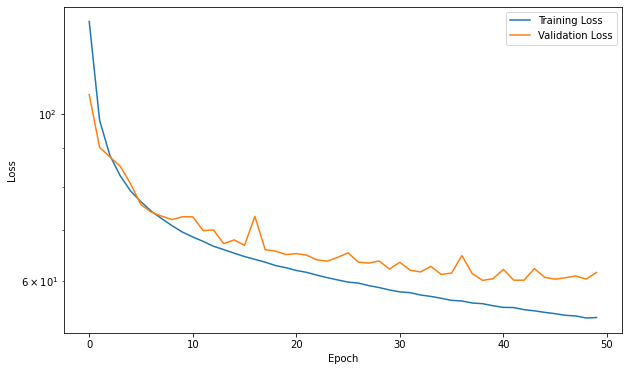

In [9]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [10]:
output = model.predict(ipd.clusters_v)

Ok, the loss function already got smaller! In the first try is was 79 after 200 epochs. But maybe this is due to the larger grid? 9 x 9?

Let's check it out...

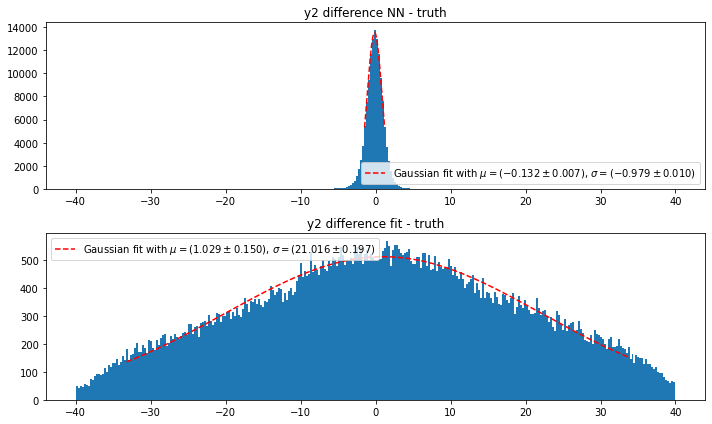

(array([-1.32346317e-01, -9.79114103e-01,  3.31311598e+04]),
 array([7.01960852e-03, 9.72588840e-03, 2.62765565e+02]),
 array([1.02911843e+00, 2.10161338e+01, 2.70003961e+04]),
 array([1.50266746e-01, 1.96979425e-01, 2.04282889e+02]))

In [11]:
mf.histo_output(output.T[4], ipd.veri_fit.T[4], ipd.veri_truth.T[4], name="y2", range_x=(-40,40))

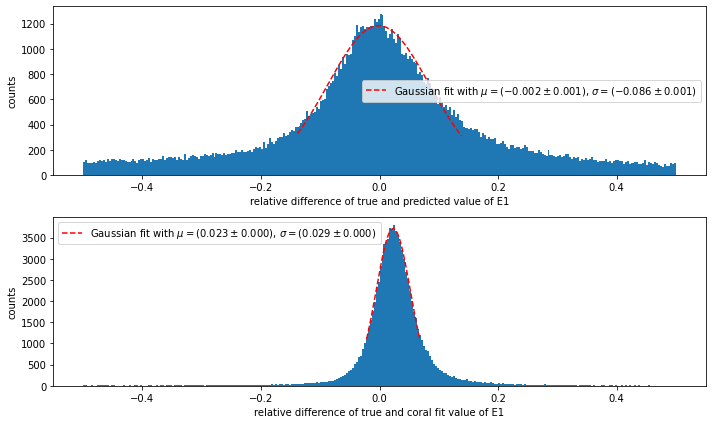

In [12]:
E_bad = mf.histo_output_relE(output.T[2], ipd.veri_fit.T[2], ipd.veri_truth.T[2], name="E1", range_x=(-0.5,0.5), fit=True)

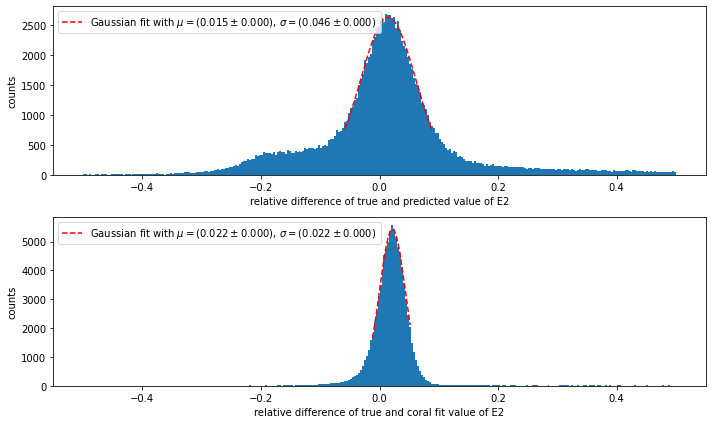

In [13]:
E_bad = mf.histo_output_relE(output.T[5], ipd.veri_fit.T[5], ipd.veri_truth.T[5], name="E2", range_x=(-0.5,0.5), fit=True)

Let's try a higher learning rate? It seems a bit slow maybe?

In [14]:
model1 = keras.Sequential([layers.Input(shape=(81)),
                         layers.Normalization(mean=2.5, variance=13.4),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(512, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(6, activation=None)])
model1.summary()
model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.005))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 81)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               10496     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [15]:
a = time.time()
fit_hist1 = model1.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=50, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/50
7405/7405 [==============================] - 18s 2ms/step - loss: 138.4893 - val_loss: 114.0973
Epoch 2/50
7405/7405 [==============================] - 18s 2ms/step - loss: 107.7162 - val_loss: 104.3203
Epoch 3/50
7405/7405 [==============================] - 18s 2ms/step - loss: 97.8552 - val_loss: 102.5321
Epoch 4/50
7405/7405 [==============================] - 17s 2ms/step - loss: 91.8633 - val_loss: 89.1304
Epoch 5/50
7405/7405 [==============================] - 17s 2ms/step - loss: 88.0666 - val_loss: 94.8025
Epoch 6/50
7405/7405 [==============================] - 17s 2ms/step - loss: 85.4025 - val_loss: 88.3219
Epoch 7/50
7405/7405 [==============================] - 17s 2ms/step - loss: 83.4630 - val_loss: 86.2709
Epoch 8/50
7405/7405 [==============================] - 18s 2ms/step - loss: 81.7534 - val_loss: 82.6302
Epoch 9/50
7405/7405 [==============================] - 18s 2ms/step - loss: 79.9325 - val_loss: 80.5571
Epoch 10/50
7405/7405 [===========================

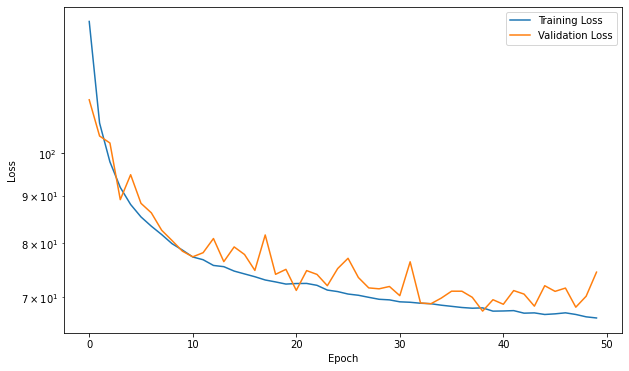

In [16]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist1)

naja, der loss ist hoeher als davor!

Ok, lass wir den ersten Versuch doch noch bissi laufen...

In [17]:
a = time.time()
fit_hist2 = model.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=150, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/150
7405/7405 [==============================] - 18s 2ms/step - loss: 53.2422 - val_loss: 59.3171
Epoch 2/150
7405/7405 [==============================] - 18s 2ms/step - loss: 53.0723 - val_loss: 60.4030
Epoch 3/150
7405/7405 [==============================] - 18s 2ms/step - loss: 53.0516 - val_loss: 59.7333
Epoch 4/150
7405/7405 [==============================] - 18s 2ms/step - loss: 52.6898 - val_loss: 61.7088
Epoch 5/150
7405/7405 [==============================] - 18s 2ms/step - loss: 52.4659 - val_loss: 60.1661
Epoch 6/150
7405/7405 [==============================] - 18s 2ms/step - loss: 52.3644 - val_loss: 59.2463
Epoch 7/150
7405/7405 [==============================] - 18s 2ms/step - loss: 52.2603 - val_loss: 59.3370
Epoch 8/150
7405/7405 [==============================] - 18s 2ms/step - loss: 51.9983 - val_loss: 59.1583
Epoch 9/150
7405/7405 [==============================] - 18s 2ms/step - loss: 51.8882 - val_loss: 59.9472
Epoch 10/150
7405/7405 [======================

7405/7405 [==============================] - 17s 2ms/step - loss: 45.2695 - val_loss: 56.8831
Epoch 78/150
7405/7405 [==============================] - 18s 2ms/step - loss: 45.2421 - val_loss: 57.6377
Epoch 79/150
7405/7405 [==============================] - 18s 2ms/step - loss: 45.1324 - val_loss: 57.5422
Epoch 80/150
7405/7405 [==============================] - 18s 2ms/step - loss: 44.9474 - val_loss: 58.5185
Epoch 81/150
7405/7405 [==============================] - 18s 2ms/step - loss: 44.9377 - val_loss: 59.9350
Epoch 82/150
7405/7405 [==============================] - 18s 2ms/step - loss: 44.9841 - val_loss: 57.0010
Epoch 83/150
7405/7405 [==============================] - 18s 2ms/step - loss: 44.9217 - val_loss: 58.7610
Epoch 84/150
7405/7405 [==============================] - 18s 2ms/step - loss: 44.9348 - val_loss: 57.5222
Epoch 85/150
7405/7405 [==============================] - 18s 2ms/step - loss: 44.7923 - val_loss: 62.4147
Epoch 86/150
7405/7405 [==========================

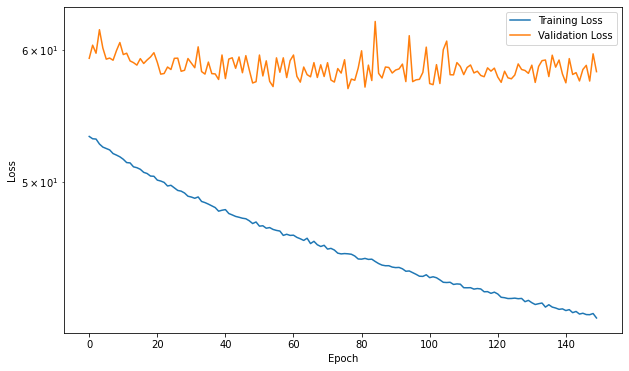

In [18]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist2)

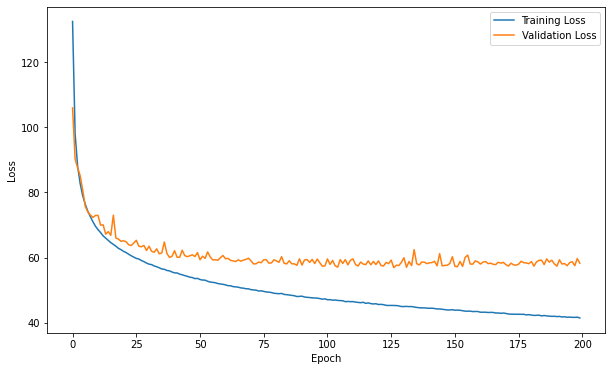

In [19]:
plt.plot(np.concatenate((fit_hist.history['loss'], fit_hist2.history['loss'])))
plt.plot(np.concatenate((fit_hist.history['val_loss'], fit_hist2.history['val_loss'])))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

In [20]:
output2 = model.predict(ipd.clusters_v)

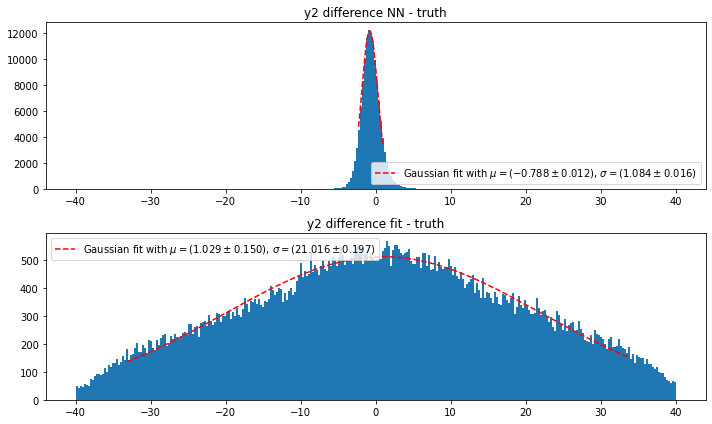

(array([-7.88094808e-01,  1.08437884e+00,  3.31299047e+04]),
 array([1.16921361e-02, 1.56291941e-02, 3.83190717e+02]),
 array([1.02911843e+00, 2.10161338e+01, 2.70003961e+04]),
 array([1.50266746e-01, 1.96979425e-01, 2.04282889e+02]))

In [21]:
mf.histo_output(output2.T[4], ipd.veri_fit.T[4], ipd.veri_truth.T[4], name="y2", range_x=(-40,40))

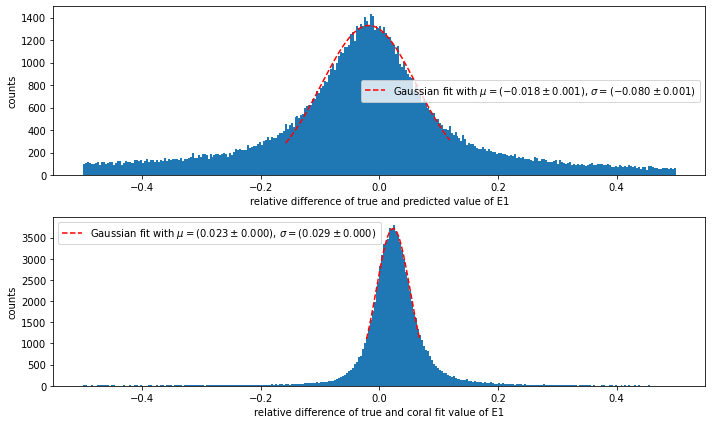

In [22]:
E_bad = mf.histo_output_relE(output2.T[2], ipd.veri_fit.T[2], ipd.veri_truth.T[2], name="E1", range_x=(-0.5,0.5), fit=True)

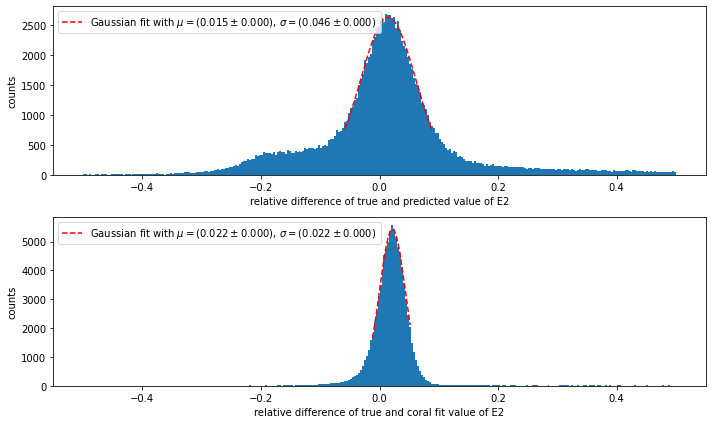

In [23]:
E_bad = mf.histo_output_relE(output.T[5], ipd.veri_fit.T[5], ipd.veri_truth.T[5], name="E2", range_x=(-0.5,0.5), fit=True)

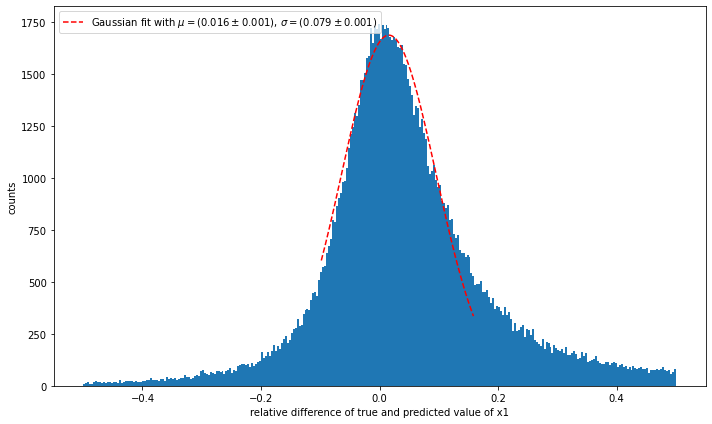

(array([23.48485522,  5.28218391,  3.63958585, ..., 24.45792999,
        12.16566316,  9.11892637]),
 array([ 7.84951175, 69.08893527, 33.34417731, ..., 45.56392665,
        19.33145804,  2.46579317]))

In [24]:
mf.histo_output_relxy(output2.T[0], ipd.veri_truth.T[0], ipd.veri_truth.T[2], name='x1', range_x=(-0.5,0.5))

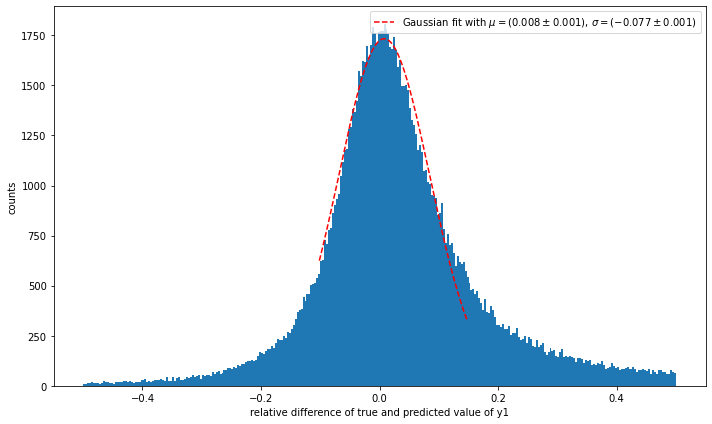

(array([25.82727316, 19.88106569, 24.87958364, ...,  5.09319332,
        11.42204063, 17.52726565]),
 array([25.82727316, 19.88106569, 24.87958364, ...,  5.09319332,
        11.42204063, 17.52726565]))

In [25]:
mf.histo_output_relxy(output2.T[1], ipd.veri_truth.T[1], ipd.veri_truth.T[1], name='y1', range_x=(-0.5,0.5))

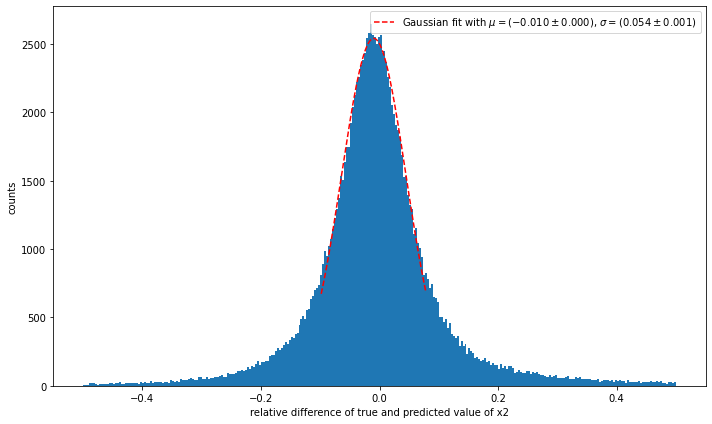

(array([ 9.13729146, 22.32074376,  8.34061348, ..., 10.35609211,
        15.77640438,  4.89738701]),
 array([ 9.13729146, 22.32074376,  8.34061348, ..., 10.35609211,
        15.77640438,  4.89738701]))

In [26]:
mf.histo_output_relxy(output2.T[3], ipd.veri_truth.T[3], ipd.veri_truth.T[3], name='x2', range_x=(-0.5,0.5))

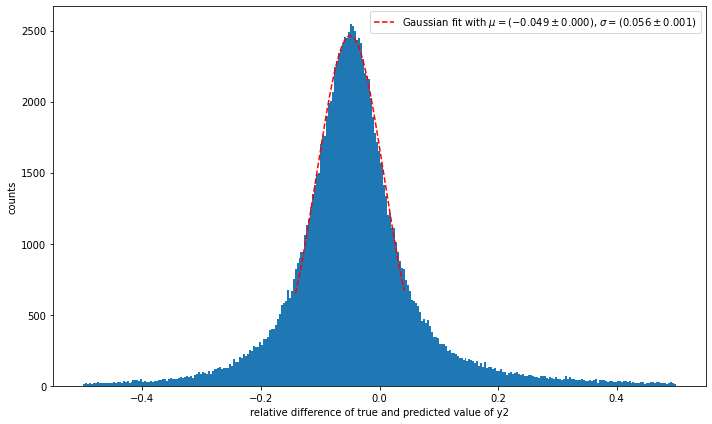

(array([23.10052989, 17.85144694,  9.86507906, ..., 11.91754508,
         4.07531073,  6.716499  ]),
 array([23.10052989, 17.85144694,  9.86507906, ..., 11.91754508,
         4.07531073,  6.716499  ]))

In [27]:
mf.histo_output_relxy(output2.T[4], ipd.veri_truth.T[4], ipd.veri_truth.T[4], name='y2', range_x=(-0.5,0.5))

In [28]:
model.save('stage4_network1')

INFO:tensorflow:Assets written to: stage4_network1/assets


In [29]:
def mega_plot(output, truth, coral):
    plt.rcParams["figure.figsize"] = (10,6)
    bins= 300
    range_x = (-0.5, 0.5)
    
    # BILD 1 - rel E fuer E1
    plt.subplot(2,2,1)
    n_counts, bins, patches = plt.hist((output.T[2]-truth.T[2])/truth.T[2], bins=bins, range=range_x)
    # fit
    maxv = n_counts.max()
    ind_fit = np.where(n_counts > 0.3*maxv)
    liml = ind_fit[0].min()
    limu = ind_fit[0].max() + 1

    x_centers = 0.5*(bins[:-1]+bins[1:])
    popt1, pcov1 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
    perr1 = np.sqrt(np.diag(pcov1))
    x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
    y_fit = gaus(x_fit, *popt1)
    plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt1[1], perr1[1]))
    plt.legend()
    plt.xlabel("relative difference of true and predicted value of " + name)
    plt.ylabel("counts")

    # which values does NN not learn correctly (energy)?
    ind_bad = np.where(abs((arr_NN-arr_truth)/arr_truth) > num_sig * popt1[1]) # all events further away than 1 sigma
    values_bad = arr_NN[ind_bad]
    
    # BILD 2 - rel E fuer E1 coral fit
    plt.subplot(2,2,2)
    n_counts, bins, patches = plt.hist((arr_fit-arr_truth)/arr_truth, bins=bins, range=range_x)

    
    if fit==True:
        # fit
        maxv = n_counts.max()
        ind_fit = np.where(n_counts > 0.3*maxv)
        liml = ind_fit[0].min()
        limu = ind_fit[0].max() + 1

        x_centers = 0.5*(bins[:-1]+bins[1:])
        popt2, pcov2 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
        perr2 = np.sqrt(np.diag(pcov2))
        x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
        y_fit = gaus(x_fit, *popt2)
        plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt2[0], perr2[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt2[1], perr2[1]))
        plt.legend()
        plt.xlabel("relative difference of true and coral fit value of " + name)
        plt.ylabel("counts")
    
    plt.tight_layout()
    if figsave == True:
        plt.savefig(name+"_histo.pdf")
    plt.show()